# Домашнее задание 5.

Ниже приведено решение задачи Walmart TripType prediction.

Сначала мы строим простую baseline модель используя алгоритм случайного леса, затем делаем Exploratory Data Analysis, и наконец генерим новый набор признаков и на нем обучаем алгоритм градиентного бустинга.

Разберитесь в этом нотбуке: 
- в чем заключается задача?
- какие признаки мы генерим?

Существует 3 популярные библиотеки реализующие алгоритм градиентного бустинга:
- xgboost https://xgboost.readthedocs.io/en/stable/python/python_intro.html
- catboost https://catboost.ai/en/docs/concepts/python-quickstart
- lightgbm https://lightgbm.readthedocs.io/en/latest/Python-Intro.html

 
Решение отправляйте на почту kurmukovai@gmail.com, до полуночи 24 марта, 23:59:59 с темой письма [iitp-intro-ds-2024-ha5-Surname], например [iitp-intro-ds-2024-ha5-Kurmukov]

* если вам нужно будет обработать пропуски (missing values) обрабатывайте их любым разумным образом (см. семинар 3)
* все 3 библиотеки умеют работать с категориальным переменными "из коробки":
- https://xgboost.readthedocs.io/en/stable/tutorials/categorical.html
- https://lightgbm.readthedocs.io/en/latest/Advanced-Topics.html

возможно необходимо строковые признаки закодировать в числа 1..n .

# п. 1-5 смотрите ниже


Данные без пароля можно скачать тут https://disk.yandex.ru/d/xTXpgXJwiWyYSQ

Ниже предложено два baseline решения, изучите их прежде чем переходить к разделам 6-7.


# 6. Вопросы про данные

В вопросах про данные используйте выборку `train.csv`

1. Сколько всего уникальных типов покупок (TripType) в данной задаче?
2. В какой день недели совершается больше всего покупок?
3. Какой мультиклассовой точности соответствует логлосс 0.997 в данной задаче?
4. Опишите качественно самый частый и самый редкий типы покупок в данных: в какой день они происходят, каким категорям товаров соответствуют, какой в них средний размер чека (количество позиций) и т.д.


# 7. Compare `xgboost`, `catboost` and `lightgbm`

Ваша задача состоит в том чтобы познакомиться с 3 имплементациями градиентного бустинга. Перед вами нет задачи выбить "наилучшее" качество. 

1. Отредактируйте п.4. Разделите данные `train.csv` на тренировочную и тестовую выборки в отношении 8 к 2.

2. Запустите модели `xgboost`, `lightgbm` и `catboost` с гиперпараметрами предложенными выше для `catboost`:
```
ctb_params = {
    'depth': 4,
    'learning_rate': .3,
    'loss_function': 'MultiClass',
    'iterations': 100
}
```
остальные гиперпараметры моделей используйте "по умолчанию". Сравните качество полученных моделей на "внутренней" тестовой выборке из вопроса 1 в терминах логистического лосса и в терминах мультиклассовой точности (multi-class accuracy).

3. Перечислите какие гиперпараметры для регуляризации существуют в трех имплементациях градиентного бустинга. Какие из них повторяются, а какие отличаются?

4. Повторите п.2, но теперь в качестве гиперпараметров в моделях используйте параметры по-умолчанию из `lightgbm`:
`num_leaves`, `learning_rate`, `n_estimators`. Сравните результаты с результатами из вопроса 2. 

5. (по возможности) сделайте предсказание лучшей из моделей на тестовой выборке (test.csv) для которой у вас нет столбца `TripType`, засабмитьте результат на kaggle и сравните оценки logloss между внутренним и отложенным тестом, прокомментируйте результат.


# Walmart TripType prediction

https://www.kaggle.com/c/walmart-recruiting-trip-type-classification

>For this competition, you are tasked with categorizing shopping trip types based on the items that customers purchased. To give a few hypothetical examples of trip types: a customer may make a small daily dinner trip, a weekly large grocery trip, a trip to buy gifts for an upcoming holiday, or a seasonal trip to buy clothes.


## Multi-class classification, goal is to predict `type of the trip`.

In [8]:
# !kaggle competitions download -c walmart-recruiting-trip-type-classification
# !unzip walmart-recruiting-trip-type-classification.zip
# !unzip train.csv.zip

Archive:  train.csv.zip
  inflating: train.csv               


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [9]:
train = pd.read_csv('train.csv')
# test = pd.read_csv('walmart-recruiting-trip-type-classification/test.csv')

In [10]:
train.head()

,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber
0,999,5,Friday,6.811315e+10,-1,FINANCIAL SERVICES,1000.0
1,30,7,Friday,6.053882e+10,1,SHOES,8931.0
2,30,7,Friday,7.410811e+09,1,PERSONAL CARE,4504.0
3,26,8,Friday,2.238404e+09,2,PAINT AND ACCESSORIES,3565.0
4,26,8,Friday,2.006614e+09,2,PAINT AND ACCESSORIES,1017.0


### Columns description

- `TripType` - a categorical id representing the type of shopping trip the customer made. This is the ground truth that you are predicting. TripType_999 is an "other" category.
- `VisitNumber` - an id corresponding to a single trip by a single customer
- `Weekday` - the weekday of the trip
- `Upc`- the UPC number of the product purchased
- `ScanCount` - the number of the given item that was purchased. A negative value indicates a product return.
- `DepartmentDescription` - a high-level description of the item's department
- `FinelineNumber` - a more refined category for each of the products, created by Walmart


In [11]:
train.shape

(647054, 7)

In [12]:
train.count()

TripType                 647054
VisitNumber              647054
Weekday                  647054
Upc                      642925
ScanCount                647054
DepartmentDescription    645693
FinelineNumber           642925
dtype: int64

In [13]:
train.TripType.value_counts()

40     174164
39      95504
37      38954
38      29565
25      27609
7       23199
8       22844
36      21990
44      20424
42      19468
24      18015
999     17590
9       16820
32      13843
5       13836
35      12501
33       9918
15       7147
3        6827
43       6383
41       5508
30       4861
34       4751
27       4613
21       4032
22       3592
6        3405
20       3116
18       2977
28       2664
26       2507
12       2108
29       2105
31       1765
19       1188
4         901
23        325
14         35
Name: TripType, dtype: int64

# 1. Understand the task.

> Every single ml task has its features, and there are no universal solutions, only generally working principles.

We need to predict type of the visit: `TripType`. Every row of the data table contains information about a single product not a visit, threfore we need to combine the information about the visit from all the purchases. 

![](trip-type.png)

Unfortunately, we do not have the information about customers, so we do not know if some of the Visits were performed by the same person.


In [14]:
train.head(5)

,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber
0,999,5,Friday,6.811315e+10,-1,FINANCIAL SERVICES,1000.0
1,30,7,Friday,6.053882e+10,1,SHOES,8931.0
2,30,7,Friday,7.410811e+09,1,PERSONAL CARE,4504.0
3,26,8,Friday,2.238404e+09,2,PAINT AND ACCESSORIES,3565.0
4,26,8,Friday,2.006614e+09,2,PAINT AND ACCESSORIES,1017.0


# 2. Build a simple baseline model

- Count number of purchases in a Visit
- Create binary column `is_weekend`
- Drop all the remaining columns

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder

In [16]:
def is_weekend(day):
    return int(day in ['Saturday', 'Sunday'])

df_train = train.copy()

# Generate is_weekend
df_train['is_weekend'] = df_train.Weekday.apply(is_weekend)

# Generate n_products
gp_n_products = df_train.groupby('VisitNumber')['ScanCount'].count()
df_train['n_products'] = df_train.VisitNumber.map(gp_n_products)

# drop duplicated Visit numbers
df_train = df_train.drop_duplicates(subset=['VisitNumber']).reset_index(drop=True)

# drop all columns except `is_weekend`, `n_products` and `TripType`
df_train = df_train.drop(['VisitNumber', 'Weekday', 'Upc', 'ScanCount',
                          'DepartmentDescription', 'FinelineNumber'], axis=1)

# Encode TripType so unique values are from 0 to (m-1), where m is number of classes
encoder = LabelEncoder().fit(df_train['TripType'])
df_train['TripType_encoded'] =  encoder.transform(df_train['TripType'])
df_train = df_train.drop('TripType', axis=1)

# Create separate variables X and y
X = df_train.drop('TripType_encoded', axis=1)
y = df_train.TripType_encoded

In [17]:
from sklearn.model_selection import train_test_split

In [18]:
# Split data into train and test, use parameter `stratify=y`

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=774, stratify=y)

In [19]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import log_loss

In [20]:
# train a RandomForest model with default hyperparameters

clf = RandomForestClassifier()
clf.fit(X_train, y_train)

RandomForestClassifier()

---
For this tash we are using a log loss $$- y \log p - (1-y)\log(1-p)$$
in the following multi class form:

$$\frac{1}{N}\sum_{i=1}^N \log {\left(\frac{e^{a_{it_i}}}{\sum_{j=0}^{M-1} e^{a_{ij}}}\right)}$$

$t \in \{0\ldots M-1\}$, $M$ is number of classes, $N$ is number of objects. Numerator is $a_{it_{i}}$ = \[ unnormalized probability of an $i$'th object to be assigned to the right class $t_i$\], thus:

$$p_{it_i} = \frac{e^{a_{it_i}}}{\sum_{j=0}^{M-1} e^{a_{ij}}}$$

see for example https://towardsdatascience.com/cross-entropy-for-classification-d98e7f974451

In [21]:
# predict y_test and compute multi-class log loss of your prediction

y_pred = clf.predict_proba(X_test)
log_loss(y_test, y_pred)

/homes/anvar/anaconda3/envs/cuda311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:2916: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(


2.6319043048286748

In [22]:
y_pred.shape

(19135, 38)

In [23]:
from sklearn.metrics import accuracy_score

In [24]:
# just to get an intuition on whether it is a good a bad prediction compute an accuracy of your model

y_pred = clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.27640449438202247

In [25]:
# Remember this is a 38 class classification, count predicted classes

np.unique(y_pred, return_counts=True)

(array([ 5, 31, 32]), array([9480, 7923, 1732]))

In [26]:
# Check value counts of a TripType on a train set

y_train.value_counts()

5     9729
31    7917
6     7571
37    6755
32    4904
4     4602
2     3674
17    2958
0     2914
28    2404
30    2330
29    2230
16    2087
27    1624
24    1587
34    1486
25    1052
3     1022
36     950
22     865
9      782
14     742
35     698
19     628
26     575
13     513
12     510
23     475
33     466
10     439
18     403
20     394
21     347
11     300
1      277
7      215
15     111
8        3
Name: TripType_encoded, dtype: int64

## Compare with the constant prediction


In [27]:
# Compute a log loss and an accuracy of a constant prediction (predict most frequent TripType)

y_dummy = [5]*19135
print(accuracy_score(y_test, y_dummy))

y_dummy_proba = np.zeros((19135, 38))
y_dummy_proba[:, 5] = 1
print(log_loss(y_test, y_dummy_proba))

0.1270969427750196
31.462615236917888


/homes/anvar/anaconda3/envs/cuda311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:2916: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(


## Conclusions on the baseline
1. Even with this simple features and relatively stupid predictions we are better than a constant prediction.
2. Classifier mostly predicts frequent classes.
3. Some frequent classes are predicted and some are not. This may be due to the fact that predicted
classes are better described by the generated features.

# 3. Deeper look on the features.

### Columns description

- `TripType` - a categorical id representing the type of shopping trip the customer made. This is the ground truth that you are predicting. TripType_999 is an "other" category.
- `VisitNumber` - an id corresponding to a single trip by a single customer
- `Weekday` - the weekday of the trip
- `Upc`- the UPC number of the product purchased
- `ScanCount` - the number of the given item that was purchased. A negative value indicates a product return.
- `DepartmentDescription` - a high-level description of the item's department
- `FinelineNumber` - a more refined category for each of the products, created by Walmart


In [28]:
train.head()

,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber
0,999,5,Friday,6.811315e+10,-1,FINANCIAL SERVICES,1000.0
1,30,7,Friday,6.053882e+10,1,SHOES,8931.0
2,30,7,Friday,7.410811e+09,1,PERSONAL CARE,4504.0
3,26,8,Friday,2.238404e+09,2,PAINT AND ACCESSORIES,3565.0
4,26,8,Friday,2.006614e+09,2,PAINT AND ACCESSORIES,1017.0


In [29]:
train.dtypes

TripType                   int64
VisitNumber                int64
Weekday                   object
Upc                      float64
ScanCount                  int64
DepartmentDescription     object
FinelineNumber           float64
dtype: object

All features, except `ScanCount` are categorical, a negative value of a `ScanCount` indicates a product return.

### 3.1 VisitNumber 
is an indicator of a visit, we need it to aggregate different purchases,
but the number itself is not important it is just an index. Let's have a quick look on it.

In [30]:
train.VisitNumber.value_counts()

72439    209
88011    151
9181     113
60971    112
65792    111
        ... 
97089      1
97094      1
103        1
107        1
117        1
Name: VisitNumber, Length: 95674, dtype: int64

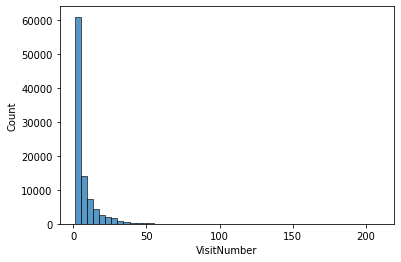

In [31]:
sns.histplot(data=train.VisitNumber.value_counts(), bins=50);

In [32]:
train.VisitNumber.value_counts().value_counts().sort_index()[:20]

1     19563
2     17255
3     10362
4      8038
5      5884
6      4633
7      3716
8      3154
9      2593
10     2251
11     1889
12     1746
13     1519
14     1253
15     1207
16     1030
17      887
18      772
19      699
20      674
Name: VisitNumber, dtype: int64

--- 

- More than half of all Visit consists of 4 or less purchases
- 90% of Visits consist of 17 or less purchases

### 3.2 Weekday

In [33]:
# How many visits are on different weekdays
weekdays = ['Monday', 'Tuesday', 'Wednesday','Thursday','Friday', 'Saturday', 'Sunday']

train.Weekday.value_counts().reindex(weekdays)

Monday        83130
Tuesday       72529
Wednesday     71115
Thursday      67962
Friday        96247
Saturday     122096
Sunday       133975
Name: Weekday, dtype: int64

In [34]:
# Do we have more returns on some weekdays?

train['IsReturn'] = train['ScanCount'].apply(lambda x: x < 0)
train.groupby(['Weekday'])['IsReturn'].sum().sort_values().reindex(weekdays)

Weekday
Monday       1926
Tuesday      1878
Wednesday    1871
Thursday     1793
Friday       2418
Saturday     2763
Sunday       2809
Name: IsReturn, dtype: int64

In [35]:
# Is there only `-1` returns?

train[train.IsReturn].ScanCount.value_counts()

-1     14394
-2       814
-3       143
-4        76
-5        16
-6        10
-9         2
-12        1
-7         1
-10        1
Name: ScanCount, dtype: int64

### 3.3 DepartmentDescription

In [36]:
# What are the most popular Departments? (total sum over ScanCount)

train.groupby('DepartmentDescription').ScanCount.sum().sort_values(ascending=False)[:20]

DepartmentDescription
GROCERY DRY GOODS              88718
DSD GROCERY                    79814
PRODUCE                        52813
DAIRY                          50550
PERSONAL CARE                  44819
IMPULSE MERCHANDISE            31811
HOUSEHOLD CHEMICALS/SUPP       26915
PHARMACY OTC                   25620
FROZEN FOODS                   25368
HOUSEHOLD PAPER GOODS          17986
COMM BREAD                     17516
BEAUTY                         15077
INFANT CONSUMABLE HARDLINES    13149
PETS AND SUPPLIES              12592
CANDY, TOBACCO, COOKIES        11745
MENS WEAR                      11690
MEAT - FRESH & FROZEN          10882
SERVICE DELI                   10777
PRE PACKED DELI                10722
CELEBRATION                     9957
Name: ScanCount, dtype: int64

In [37]:
# Does most popular DepartmentDescription differ for different TripTypes?
# > Allows to more or less deanonymize `TripType`.

gp = train.groupby('TripType')['DepartmentDescription'].value_counts().reset_index(name='Count')
gp2 = gp.groupby(['TripType'])[['Count','DepartmentDescription']]\
                                                           .apply(pd.DataFrame.nlargest, n=3, columns=['Count'])\
                                                           .reset_index()\
                                                           .drop('level_1', axis=1)

gp2[:15]

,TripType,Count,DepartmentDescription
0,3,5369,FINANCIAL SERVICES
1,3,804,IMPULSE MERCHANDISE
2,3,76,LARGE HOUSEHOLD GOODS
3,4,563,PHARMACY OTC
4,4,73,DSD GROCERY
5,4,47,IMPULSE MERCHANDISE
6,5,5281,PHARMACY OTC
7,5,2714,PHARMACY RX
8,5,922,PERSONAL CARE
9,6,1000,"LIQUOR,WINE,BEER"


In [38]:
# From our baseline, recall most popular TripTypes, let's deanonymize them.
# Select subset of the previous table with TripType in [40, 39, 37, 38, 25]

gp2[gp2.TripType.isin([40, 39, 37, 38, 25])]

,TripType,Count,DepartmentDescription
51,25,5381,MENS WEAR
52,25,3716,LADIESWEAR
53,25,1836,"GIRLS WEAR, 4-6X AND 7-14"
87,37,13351,PRODUCE
88,37,5477,GROCERY DRY GOODS
89,37,3667,DAIRY
90,38,7252,DAIRY
91,38,6417,GROCERY DRY GOODS
92,38,4020,DSD GROCERY
93,39,12956,DSD GROCERY


In [39]:
# What are the DepartmentDescription with most returns?

train.groupby('DepartmentDescription')['IsReturn'].sum().sort_values(ascending=False)[:15]

DepartmentDescription
FINANCIAL SERVICES          1162
LADIESWEAR                   800
PRODUCE                      733
PERSONAL CARE                682
DSD GROCERY                  679
MENS WEAR                    634
GROCERY DRY GOODS            606
PHARMACY OTC                 472
IMPULSE MERCHANDISE          453
BEAUTY                       452
ELECTRONICS                  450
HOUSEHOLD CHEMICALS/SUPP     392
COOK AND DINE                382
TOYS                         356
DAIRY                        343
Name: IsReturn, dtype: int64

### 3.4 FinelineNumber

> according to the data description `FinelineNumber` is just a more detailed `DepartmentDescription`

In [40]:
# Build a crosstab between DepartmentDescription and FinelineNumber,
# for most popular DepartmentDescription (total ScanCount > 20_000)
# and most popular FinelineNumber (total ScanCount > 2000)


popular_dd = train.groupby('DepartmentDescription').ScanCount.sum().sort_values(ascending=False)[:10].index
sub = train[train.DepartmentDescription.isin(popular_dd)]
sub = sub[sub.FinelineNumber.isin(sub.FinelineNumber.value_counts().iloc[:15].index)]

tab = pd.crosstab(sub.FinelineNumber, sub.DepartmentDescription)
tab

DepartmentDescription,DAIRY,DSD GROCERY,GROCERY DRY GOODS,HOUSEHOLD CHEMICALS/SUPP,HOUSEHOLD PAPER GOODS,IMPULSE MERCHANDISE,PERSONAL CARE,PHARMACY OTC,PRODUCE
FinelineNumber,,,,,,,,,
100.0,0,0,95,0,0,2354,0,0,69
110.0,0,0,0,536,770,773,0,0,0
115.0,0,0,0,10,0,2576,0,0,0
135.0,0,0,0,0,0,4417,26,0,0
203.0,0,0,0,0,69,0,2353,0,0
808.0,0,0,0,0,0,4200,140,0,0
1407.0,2659,0,0,0,0,0,177,0,0
1508.0,4961,0,0,0,0,0,0,0,0
3004.0,0,1074,109,0,587,0,0,0,486


### 3.5 Upc

In [41]:
train.Upc.value_counts()

4.011000e+03    7657
6.053886e+10    2501
7.874235e+09    2067
7.874235e+09    1883
4.046000e+03    1652
                ... 
8.874118e+10       1
8.363210e+10       1
2.800045e+09       1
3.916612e+09       1
2.899522e+09       1
Name: Upc, Length: 97714, dtype: int64

## Conclusions on EDA

 - Visits are mostly consist of small number of products
 - Large visits are on weekends
 - `TripType` depends on `DepartmentDescription` and `FinelineNumber`
 - `Upc` is something like a bar code, could be usefull but contains almost 100k unique values
 

# 4. Generate features

In [42]:
train = pd.read_csv('train.csv')
# test = pd.read_csv('walmart-recruiting-trip-type-classification/test.csv')

In [43]:
def return_nth(x, n=0):
    try:
        return x[n]
    except:
        return np.nan
    
def return_nth_val(x, n=0):
    try:
        return x[n]
    except:
        return 0
    
def is_weekend(x):
    return int(x in ['Sunday', 'Saturday'])

def has_return(x):
    return int(any(_x < 0 for _x in x))

def sum_return(x):
    return np.sum([_x for _x in x if _x < 0])

In [44]:
df = train.copy()

In [45]:
def generate_features(df):
    
    df = df.copy()
    
    # 1. Most frequent DepartmentDescription in the purchase, second most frequent, third, fourth.
    f = lambda grp: grp.value_counts().nlargest(6)
    x = df.groupby('VisitNumber')['DepartmentDescription'].apply(f).reset_index()
    gp = x.groupby('VisitNumber')['level_1'].unique()

    df['PopularCategory'] = df.VisitNumber.map(gp)
    for i in range(4):
        df[f'Category_{i}'] = df['PopularCategory'].apply(return_nth, args=[i])

    # 2. Same for FinelineNumber, but 6
    x = df.groupby('VisitNumber')['FinelineNumber'].apply(f).reset_index()
    gp = x.groupby('VisitNumber')['level_1'].unique()

    df['PopularFineline'] = df.VisitNumber.map(gp)
    for i in range(6):
        df[f'Fineline_{i}'] = df['PopularFineline'].apply(return_nth, args=[i]).astype(object)

    # 3. Count number of unique DepartmentDescription in the purchase
    gp = df.groupby('VisitNumber')['DepartmentDescription'].nunique()
    df['#Unique_Department'] = df.VisitNumber.map(gp)

    # 4. Count number of unique FinelineNumber in the purchase.
    gp = df.groupby('VisitNumber')['FinelineNumber'].nunique()
    df['#Unique_Fineline'] = df.VisitNumber.map(gp)

    # 5. Count ScanCount (number of unique Upc in the purchase)

    gp = df.groupby('VisitNumber')['ScanCount'].count()
    df['#UniqueScanCount'] = df['VisitNumber'].map(gp)   

    # 6. Sum ScanCount

    gp = df.groupby('VisitNumber')['ScanCount'].sum()
    df['TotalScanCount'] = df['VisitNumber'].map(gp)

    # 7. Is weekend

    df['is_Weekend'] = df['Weekday'].apply(is_weekend).astype(object)

    # 8. Sum returns

    gp = df.groupby('VisitNumber')['ScanCount'].apply(sum_return)
    df['total_return'] = df.VisitNumber.map(gp)
    df['total_return'].fillna(0, inplace=True)

    # Drop old and intermediate features

    df = df.drop(['Upc', 'ScanCount', 'DepartmentDescription',
                  'FinelineNumber', 'PopularFineline', 'PopularCategory'], axis=1)

    # Drop duplicated rows (with the same VisitNumber)

    df = df.drop_duplicates(keep='first')
    
    return df

In [46]:
# Running this cell takes about 10 minutes
df = generate_features(df)

# 5. Train a model

In [47]:
# !pip install catboost

In [48]:
from catboost import CatBoostClassifier, Pool

In [49]:
for i, col in enumerate(df.columns):
    print(i-2, col, df[col].dtype)

-2 TripType int64
-1 VisitNumber int64
0 Weekday object
1 Category_0 object
2 Category_1 object
3 Category_2 object
4 Category_3 object
5 Fineline_0 object
6 Fineline_1 object
7 Fineline_2 object
8 Fineline_3 object
9 Fineline_4 object
10 Fineline_5 object
11 #Unique_Department int64
12 #Unique_Fineline int64
13 #UniqueScanCount int64
14 TotalScanCount int64
15 is_Weekend object
16 total_return float64


In [50]:
for col in df.columns:
    if col.startswith('Category'):
        df[col]=df[col].apply(str)
    if col.startswith('Fineline'):
        df[col]=df[col].apply(str)

In [51]:
train.fillna('NaN', inplace=True)
x_train, x_eval = train_test_split(df, test_size=0.1, random_state=10, shuffle=True)

cat_features = [*list(range(10)), 15]

data_train = Pool(x_train.drop(['TripType', 'VisitNumber'], axis=1), 
                  label=x_train.TripType,
                  cat_features=cat_features)

data_eval = Pool(x_eval.drop(['TripType', 'VisitNumber'], axis=1), 
                 label=x_eval.TripType,
                 cat_features=cat_features)

In [52]:
ctb_params = {
    'depth': 4,
    'learning_rate': .3,
    'l2_leaf_reg': 3,
    'loss_function': 'MultiClass',
    'verbose': 1,
    'thread_count': 12,
    'iterations': 100
}

In [53]:
model = CatBoostClassifier(**ctb_params)
model.fit(X = data_train, silent=False, eval_set=data_eval)

0:	learn: 2.5054008	test: 2.5055193	best: 2.5055193 (0)	total: 3.83s	remaining: 6m 19s
1:	learn: 2.1710096	test: 2.1674314	best: 2.1674314 (1)	total: 7.5s	remaining: 6m 7s
2:	learn: 1.9800685	test: 1.9673040	best: 1.9673040 (2)	total: 11.2s	remaining: 6m 3s
3:	learn: 1.9124552	test: 1.9081217	best: 1.9081217 (3)	total: 15.2s	remaining: 6m 4s
4:	learn: 1.8221832	test: 1.8152814	best: 1.8152814 (4)	total: 19.1s	remaining: 6m 3s
5:	learn: 1.7373269	test: 1.7270806	best: 1.7270806 (5)	total: 23.3s	remaining: 6m 5s
6:	learn: 1.6985587	test: 1.6874236	best: 1.6874236 (6)	total: 26.9s	remaining: 5m 56s
7:	learn: 1.6535540	test: 1.6445961	best: 1.6445961 (7)	total: 30.9s	remaining: 5m 54s
8:	learn: 1.6116905	test: 1.6016003	best: 1.6016003 (8)	total: 35s	remaining: 5m 53s
9:	learn: 1.5881047	test: 1.5737224	best: 1.5737224 (9)	total: 39.1s	remaining: 5m 51s
10:	learn: 1.5589367	test: 1.5466454	best: 1.5466454 (10)	total: 42.7s	remaining: 5m 45s
11:	learn: 1.5286680	test: 1.5127173	best: 1.5127

93:	learn: 1.0108751	test: 1.0232895	best: 1.0232895 (93)	total: 5m 56s	remaining: 22.8s
94:	learn: 1.0092849	test: 1.0220171	best: 1.0220171 (94)	total: 6m	remaining: 19s
95:	learn: 1.0081704	test: 1.0212303	best: 1.0212303 (95)	total: 6m 4s	remaining: 15.2s
96:	learn: 1.0074495	test: 1.0208261	best: 1.0208261 (96)	total: 6m 9s	remaining: 11.4s
97:	learn: 1.0067927	test: 1.0203077	best: 1.0203077 (97)	total: 6m 14s	remaining: 7.64s
98:	learn: 1.0038593	test: 1.0180214	best: 1.0180214 (98)	total: 6m 19s	remaining: 3.83s
99:	learn: 1.0035691	test: 1.0177677	best: 1.0177677 (99)	total: 6m 23s	remaining: 0us

bestTest = 1.017767665
bestIteration = 99



In [54]:
# model.save_model('catboost_depth=4_lr=.3_l2=3')
# model = CatBoostClassifier()